In [12]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import xgboost as xgb
import lightgbm as lgb

from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, MACCSkeys, AllChem

import warnings
warnings.filterwarnings('ignore')


In [13]:

print("데이터 로딩 중...")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

print(f"훈련 데이터 : {train.shape}")
print(f"테스트 데이터 : {test.shape}")

데이터 로딩 중...
훈련 데이터 : (1681, 3)
테스트 데이터 : (100, 2)


In [14]:

def get_molecule_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return [0] * 2232

        basic_descriptors = [
            Descriptors.MolWt(mol),
            Descriptors.MolLogP(mol),
            Descriptors.NumHAcceptors(mol),
            Descriptors.NumHDonors(mol),
            Descriptors.TPSA(mol),
            Descriptors.NumRotatableBonds(mol),
            Descriptors.NumAromaticRings(mol),
            Descriptors.NumHeteroatoms(mol),
            Descriptors.FractionCSP3(mol),
            Descriptors.NumAliphaticRings(mol),
            Lipinski.NumAromaticHeterocycles(mol),
            Lipinski.NumSaturatedHeterocycles(mol),
            Lipinski.NumAliphaticHeterocycles(mol),
            Descriptors.HeavyAtomCount(mol),
            Descriptors.RingCount(mol),
            Descriptors.NOCount(mol),
            Descriptors.NHOHCount(mol),
            Descriptors.NumRadicalElectrons(mol),
        ]

        morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        morgan_features = [int(bit) for bit in morgan_fp.ToBitString()]

        maccs_fp = MACCSkeys.GenMACCSKeys(mol)
        maccs_features = [int(bit) for bit in maccs_fp.ToBitString()]

        all_features = basic_descriptors + morgan_features + maccs_features

        return all_features
    except:
        return [0] * 2232


## 분자 특성 추출 및 데이터 전처리 과정

이 단계에서는 SMILES 문자열을 분자 특성으로 변환하고, 머신러닝 모델에 입력할 수 있는 형태로 데이터를 준비합니다.

### 처리 과정:
1. **특성 추출**: 각 SMILES를 2232차원의 특성 벡터로 변환
2. **길이 통일**: 모든 특성 벡터의 길이를 동일하게 맞춤
3. **배열 변환**: 리스트를 NumPy 배열로 변환
4. **차원 정합**: 훈련/테스트 데이터의 특성 차원을 일치시킴

In [15]:
print("분자 특성 추출 중...")

# 1. 훈련 데이터 특성 추출
# SMILES를 분자 특성으로 변환 (각 행에 대해 get_molecule_descriptors 함수 적용)
train['features'] = train['Canonical_Smiles'].apply(get_molecule_descriptors)

# 2. 훈련 데이터 길이 통일
# features 컬럼의 리스트들을 파이썬 리스트로 변환
X_train_list = train['features'].tolist()
# 각 특성 벡터의 길이 확인
feature_lengths = [len(x) for x in X_train_list]

# 만약 특성 벡터들의 길이가 다르다면 (이론적으로는 모두 2232여야 함)
if len(set(feature_lengths)) != 1:
    max_length = max(feature_lengths)
    # 짧은 벡터들을 0으로 패딩하여 길이를 맞춤
    X_train_list = [x + [0] * (max_length - len(x)) for x in X_train_list]

# 3. NumPy 배열로 변환
X_train = np.array(X_train_list)  # (샘플 수, 특성 수) 형태의 2D 배열
y_train = train['Inhibition'].values  # 타겟 변수

# 4. 테스트 데이터 특성 추출 (훈련 데이터와 동일한 과정)
test['features'] = test['Canonical_Smiles'].apply(get_molecule_descriptors)
X_test_list = test['features'].tolist()
feature_lengths = [len(x) for x in X_test_list]

# 테스트 데이터도 길이 통일
if len(set(feature_lengths)) != 1:
    max_length = max(feature_lengths)
    X_test_list = [x + [0] * (max_length - len(x)) for x in X_test_list]

# 5. 훈련/테스트 데이터 간 차원 정합
# 만약 훈련과 테스트 데이터의 특성 수가 다르다면
if X_train.shape[1] != len(X_test_list[0]):
    diff = abs(X_train.shape[1] - len(X_test_list[0]))
    if X_train.shape[1] > len(X_test_list[0]):
        # 훈련 데이터가 더 크면 테스트 데이터를 패딩
        X_test_list = [x + [0] * diff for x in X_test_list]
    else:
        # 테스트 데이터가 더 크면 훈련 데이터를 패딩
        X_train = np.array([x.tolist() + [0] * diff for x in X_train])

# 6. 최종 테스트 데이터 배열 변환
X_test = np.array(X_test_list)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"특성 벡터 구성: 기본 특성(18) + Morgan(2048) + MACCS(166) = 총 {X_train.shape[1]}개")


분자 특성 추출 중...


[21:11:53] DEPRECATION WARNING: please use MorganGenerator
[21:11:53] DEPRECATION WARNING: please use MorganGenerator
[21:11:53] DEPRECATION WARNING: please use MorganGenerator
[21:11:53] DEPRECATION WARNING: please use MorganGenerator
[21:11:53] DEPRECATION WARNING: please use MorganGenerator
[21:11:53] DEPRECATION WARNING: please use MorganGenerator
[21:11:53] DEPRECATION WARNING: please use MorganGenerator
[21:11:53] DEPRECATION WARNING: please use MorganGenerator
[21:11:53] DEPRECATION WARNING: please use MorganGenerator
[21:11:53] DEPRECATION WARNING: please use MorganGenerator
[21:11:53] DEPRECATION WARNING: please use MorganGenerator
[21:11:53] DEPRECATION WARNING: please use MorganGenerator
[21:11:53] DEPRECATION WARNING: please use MorganGenerator
[21:11:53] DEPRECATION WARNING: please use MorganGenerator
[21:11:53] DEPRECATION WARNING: please use MorganGenerator
[21:11:53] DEPRECATION WARNING: please use MorganGenerator
[21:11:53] DEPRECATION WARNING: please use MorganGenerat

X_train: (1681, 2233), X_test: (100, 2233)
특성 벡터 구성: 기본 특성(18) + Morgan(2048) + MACCS(166) = 총 2233개


In [16]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42
)


In [17]:

def normalized_rmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse / (np.max(y_true) - np.min(y_true))

def pearson_correlation(y_true, y_pred):
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    return np.clip(corr, 0, 1)

def competition_score(y_true, y_pred):
    nrmse = min(normalized_rmse(y_true, y_pred), 1)
    pearson = pearson_correlation(y_true, y_pred)
    return 0.5 * (1 - nrmse) + 0.5 * pearson

def train_and_evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    val_nrmse = normalized_rmse(y_val, y_val_pred)
    val_pearson = pearson_correlation(y_val, y_val_pred)
    val_score = competition_score(y_val, y_val_pred)
    print(f"검증 NRMSE: {val_nrmse:.4f}")
    print(f"검증 Pearson: {val_pearson:.4f}")
    print(f"검증 점수: {val_score:.4f}")
    return model, val_score


In [18]:
# XGBoost 하이퍼파라미터 그리드
param_grid = {
    'n_estimators': [300, 500, 800],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 2, 5]
}

# XGBoost 모델 생성 (GPU 버전)
xgb_model = xgb.XGBRegressor(
    tree_method='gpu_hist',  # 이것만 추가
    gpu_id=0,               # 이것만 추가
    random_state=42, 
    n_jobs=-1
)


# GridSearchCV 설정
print("GridSearchCV로 최적 하이퍼파라미터 찾는 중...")
scorer = make_scorer(competition_score, greater_is_better=True)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring=scorer,
    n_jobs=1,
    verbose=4
)

# 하이퍼파라미터 튜닝 실행
grid_search.fit(X_train_final, y_train_final)

print(f"최적 파라미터: {grid_search.best_params_}")
print(f"최적 CV 점수: {grid_search.best_score_:.4f}")




GridSearchCV로 최적 하이퍼파라미터 찾는 중...
Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
[CV 1/3] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7;, score=0.575 total time=   1.3s
[CV 2/3] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7;, score=0.584 total time=   1.1s
[CV 3/3] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.7;, score=0.598 total time=   1.1s
[CV 1/3] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8;, score=0.577 total time=   1.1s
[CV 2/3] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8;, score=0.580 total time=   1.1s
[CV 3/3] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=300, reg_alpha=0, reg

In [19]:
# 최적 모델로 검증 데이터 평가
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)

val_nrmse = normalized_rmse(y_val, y_val_pred)
val_pearson = pearson_correlation(y_val, y_val_pred)
val_score = competition_score(y_val, y_val_pred)

print(f"\n검증 데이터 성능:")
print(f"검증 NRMSE: {val_nrmse:.4f}")
print(f"검증 Pearson: {val_pearson:.4f}")
print(f"검증 점수: {val_score:.4f}")

# 최고 모델로 전체 데이터 학습 및 예측
print("\n전체 데이터로 최종 모델 훈련 중...")
final_model = xgb.XGBRegressor(**grid_search.best_params_, random_state=42, n_jobs=-1)
final_model.fit(X_train_scaled, y_train)

test_preds = final_model.predict(X_test_scaled)

# 결과 저장
submission['Inhibition'] = test_preds
submission.to_csv('xgboost_gridsearch_submission.csv', index=False)
print("예측 결과 저장: xgboost_gridsearch_submission.csv")



검증 데이터 성능:
검증 NRMSE: 0.2274
검증 Pearson: 0.5196
검증 점수: 0.6461

전체 데이터로 최종 모델 훈련 중...
예측 결과 저장: xgboost_gridsearch_submission.csv


모델 성능 시각화 저장: xgboost_model_performance.png
특성 중요도 시각화 저장: xgboost_feature_importance.png

최종 결과:
최적 하이퍼파라미터: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 800, 'reg_alpha': 0.1, 'reg_lambda': 5, 'subsample': 0.7}
교차검증 점수: 0.5970
검증 점수: 0.6461


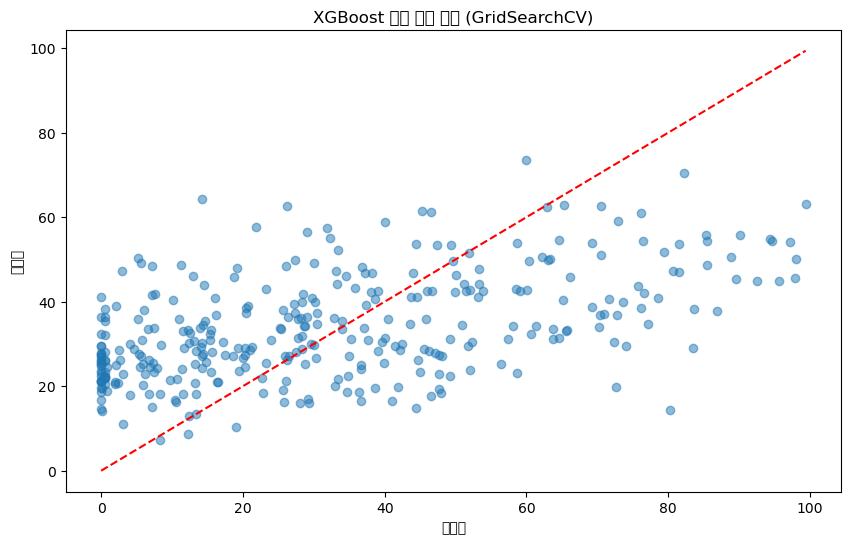

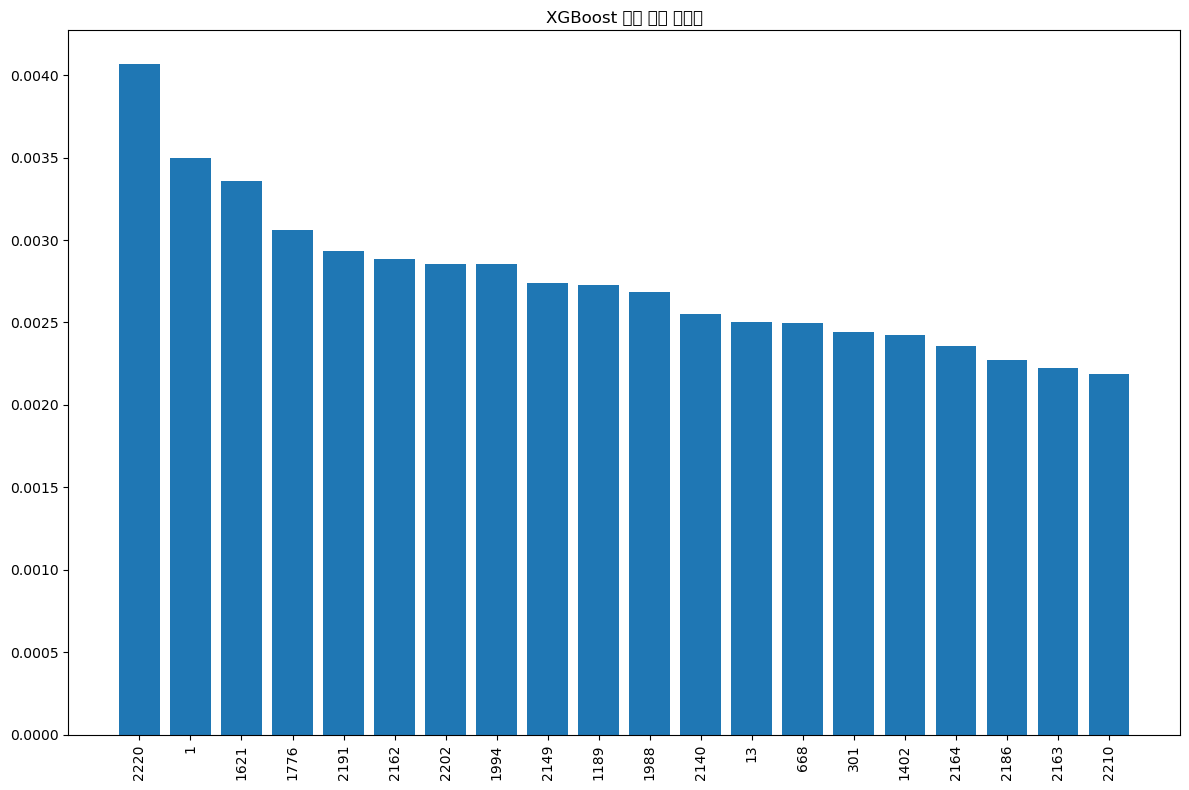

In [20]:
# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('XGBoost 모델 검증 성능 (GridSearchCV)')
plt.savefig('xgboost_model_performance.png')
print("모델 성능 시각화 저장: xgboost_model_performance.png")

# 특성 중요도 시각화
n_features = 20
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1][:n_features]
plt.figure(figsize=(12, 8))
plt.title('XGBoost 상위 특성 중요도')
plt.bar(range(n_features), importances[indices])
plt.xticks(range(n_features), indices, rotation=90)
plt.tight_layout()
plt.savefig('xgboost_feature_importance.png')
print("특성 중요도 시각화 저장: xgboost_feature_importance.png")

print(f"\n최종 결과:")
print(f"최적 하이퍼파라미터: {grid_search.best_params_}")
print(f"교차검증 점수: {grid_search.best_score_:.4f}")
print(f"검증 점수: {val_score:.4f}")